# Import libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Markers generation

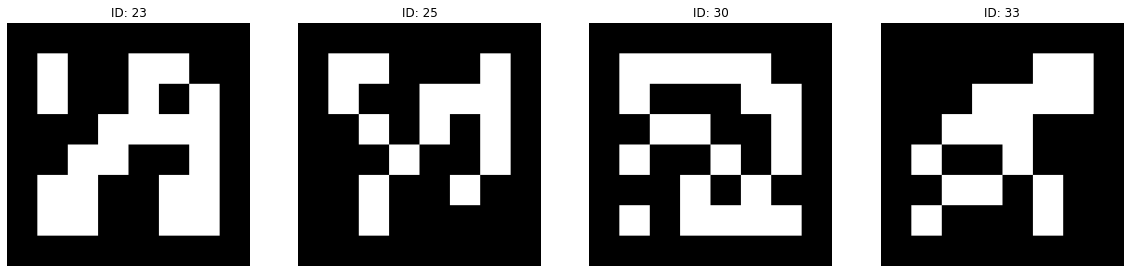

In [3]:
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
markerID = [23, 25, 30, 33]
plt.figure(figsize=(20, 20))
# Generate marker
for i in range(4):
    marker = cv2.aruco.generateImageMarker(dictionary, markerID[i], 200)
    plt.subplot(1, 4, i+1)
    plt.imshow(marker, cmap='gray')
    plt.axis('off')
    plt.title('ID: ' + str(markerID[i]))
plt.show()

# Video I/O stream configuration

In [4]:
# open camera stream
cap = cv2.VideoCapture(0)
# cap = cv2.VideoCapture('00006.mp4')
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
# cap.set(cv2.CAP_PROP_FPS, 30)
ret, frame = cap.read()

# while True:
#     ret, frame = cap.read()
#     cv2.imshow('frame', frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         cv2.destroyAllWindows()
#         break

# open video stream
# vid = cv2.VideoCapture('adu_ang_seng_1080p.mp4')
vid = cv2.VideoCapture('Ricc.mp4')
ret_vid, frame_vid = vid.read()
# pre compute the video frame size
pts_src = [[0,0], [frame_vid.shape[1], 0], [frame_vid.shape[1], frame_vid.shape[0]], [0, frame_vid.shape[0]]]
pts_src_m = np.asarray(pts_src)


KeyboardInterrupt: 

In [ ]:

while True:
    # detect markers
    # frame = cv2.imread('office_markers.jpg')
    ret, frame = cap.read()
    # handle end of video stream
    if not ret:
        break
    corners, ids, rejected = cv2.aruco.detectMarkers(frame, dictionary)

    # if all 4 markers are detected, try extracting the reference points
    if ids is not None and len(ids) == 4:
        # extract reference point coordinates from marker corners
        ref = []
        for i in range(len(ids)):
            # in order: top left, top right, bottom right, bottom left
            index = np.squeeze(np.where(ids == markerID[i]))
            ref.append(np.squeeze(corners[index[0]])[i])

        # the above code is equivalent to the following code

        # # Upper-left corner of ROI.
        # index = np.squeeze(np.where(ids == 23))
        # ref_pt1 = np.squeeze(corners[index[0]])[0]

        # # Upper-right corner of ROI.
        # index = np.squeeze(np.where(ids == 25))
        # ref_pt2 = np.squeeze(corners[index[0]])[1]

        # # Lower-right corner of ROI.
        # index = np.squeeze(np.where(ids == 30))
        # ref_pt3 = np.squeeze(corners[index[0]])[2]

        # # Lower-left corner of ROI.
        # index = np.squeeze(np.where(ids == 33))
        # ref_pt4 = np.squeeze(corners[index[0]])[3]
        
        # Rescale the ROI point to the size of the frame
        pts_dst = []
        for i in range(len(ref)):
            pts_dst += [[ref[i][0], ref[i][1]]]

        # the above code is equivalent to the following code, don't ask me why

        # # Compute horizontal and vertical distance between markers.
        # x_distance = np.linalg.norm(ref[0] - ref[1])
        # y_distance = np.linalg.norm(ref[0] - ref[2])

        # scaling_fac_x = .008  # Scale factor in x (horizontal).
        # scaling_fac_y = .012  # Scale factor in y (vertical).

        # delta_x = round(scaling_fac_x * x_distance)
        # delta_y = round(scaling_fac_y * y_distance)
        # # apply the scaling factors to the ArUco Marker reference points to make
        # # the final adjustment for the destination points
        # pts_dst = [[ref_pt1[0] - delta_x, ref_pt1[1] - delta_y]]
        # pts_dst = pts_dst + [[ref_pt2[0] + delta_x, ref_pt2[1] - delta_y]]
        # pts_dst = pts_dst + [[ref_pt3[0] + delta_x, ref_pt3[1] + delta_y]]
        # pts_dst = pts_dst + [[ref_pt4[0] - delta_x, ref_pt4[1] + delta_y]]

        # frame_vid = cv2.imread("Apollo-8-Launch.png")
        ret_vid, frame_vid = vid.read()

        pts_dst_m = np.asarray(pts_dst)
        # calculate the homography
        h, mask = cv2.findHomography(pts_src_m, pts_dst_m, cv2.RANSAC)
        # warp source image onto the destination image
        warped_image = cv2.warpPerspective(frame_vid, h, (frame.shape[1], frame.shape[0]))
        # prepare a mask representing the region to copy from the warped image into the destination frame
        mask = np.zeros([frame.shape[0], frame.shape[1]], dtype=np.uint8)
        # fill ROI in destination frame with white to create mask
        cv2.fillConvexPoly(mask, np.int32([pts_dst_m]), (255, 255, 255), cv2.LINE_AA)
        # copy the mask into 3 channels
        warped_image = warped_image.astype(float)
        mask3 = np.zeros_like(warped_image)
        for i in range(0, 3):
            mask3[:, :, i] = mask / 255
        # create inverse mask
        mask3_inv = 1 - mask3
        # create black region in destination frame ROI
        frame_masked = cv2.multiply(frame.astype(float), mask3_inv)
        # create final result by adding the warped image with the masked destination frame
        frame_out = cv2.add(warped_image, frame_masked)
        frame_out = frame_out.astype(np.uint8)

        cv2.namedWindow('frame_out', cv2.WINDOW_NORMAL)
        # cv2.setWindowProperty('frame_out', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
        cv2.imshow('frame_out', frame_out)
    else:
        frame_detected = frame.copy()
        cv2.aruco.drawDetectedMarkers(frame_detected, corners, ids)
        cv2.namedWindow('frame_out', cv2.WINDOW_NORMAL)
        # cv2.setWindowProperty('frame_out', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
        cv2.imshow('frame_out', frame_detected)
    # press esc to quit
    if cv2.waitKey(1) == 27:
        # destroy all windows btw
        cv2.destroyAllWindows()
        break
